In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
from desc import set_device

set_device("gpu")

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
from scipy.linalg import qr_insert, qr

In [4]:
from desc.basis import *
from desc.backend import *
from desc.compute import data_index
from desc.coils import SplineXYZCoil
from desc.equilibrium import *
from desc.examples import get
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import factorize_linear_constraints
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import Optimizer
from desc.perturbations import *
from desc.profiles import PowerSeriesProfile

from desc.utils import copy_coeffs, svd_inv_null

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

In [5]:
from desc.objectives.getters import _PROFILE_CONSTRAINTS
def solve_step(eq_poin, maxiter=100, plot=False, **kwargs):
    R_modes = eq_poin.R_basis.modes[eq_poin.R_basis.modes[:, 2] == 0]
    Z_modes = eq_poin.Z_basis.modes[eq_poin.Z_basis.modes[:, 2] == 0]
    L_modes = eq_poin.L_basis.modes[eq_poin.L_basis.modes[:, 2] == 0]

    cons = (
        FixModeR(eq_poin, modes=R_modes, normalize=False),
        FixModeZ(eq_poin, modes=Z_modes, normalize=False),
        BoundaryRSelfConsistency(eq_poin),
        BoundaryZSelfConsistency(eq_poin),
        AxisRSelfConsistency(eq_poin),
        AxisZSelfConsistency(eq_poin),
        # FixModeLambda(eq_poin, modes=L_modes, normalize=False),
    )
    for name, con in _PROFILE_CONSTRAINTS.items():
        if getattr(eq_poin, name) is not None:
            cons += (con(eq_poin),)
    cons += (FixSheetCurrent(eq_poin),)

    obj = ObjectiveFunction(ForceBalance(eq_poin))
    eq_poin.solve(constraints=cons, objective=obj, maxiter=maxiter, verbose=3, **kwargs);
    if plot:
        plot_comparison(eqs=[eq0, eq_poin], labels=["original", "only axisymmetric"]); 

In [6]:
def get_n0_eq(eq):
    eq_n0 = eq.copy()
    eq_n0.change_resolution(N=0, N_grid=1)
    eq_n0.change_resolution(L=eq.L, M=eq.M, N=eq.N, L_grid=eq.L_grid, M_grid=eq.M_grid, N_grid=eq.N_grid)
    
    return eq_n0

In [12]:
# eq0 = get("HELIOTRON")
eq0 = desc.io.load("low_res_isl_curr_dens_output.h5")
eq0._bdry_mode = "lcfs"
eq = eq0.copy()
eq_poincare = get_n0_eq(eq)

/CODES/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_bdry_mode' was not loaded from the file.
This is likely because the file containing 'Equilibrium' was created before '_bdry_mode' became an attribute of objects of class '<class 'desc.equilibrium.equilibrium.Equilibrium'>'.
The user may verify that a default value has been set.
This warning will persist until the file is saved with the new object.

Note to developers: Add 'def _set_up(self)' as a method to class '<class 'desc.equilibrium.equilibrium.Equilibrium'>'
(or the superclass where this new attribute is assigned) that assigns a value to '_bdry_mode'.
This method is called automatically when a file is loaded.
Recall that the testing suite will fail on warnings.
  warnings.warn(


In [13]:
eq_poincare

Equilibrium at 0x7f7a04397a10 (L=16, M=16, N=8, NFP=2, sym=True, spectral_indexing=ansi)

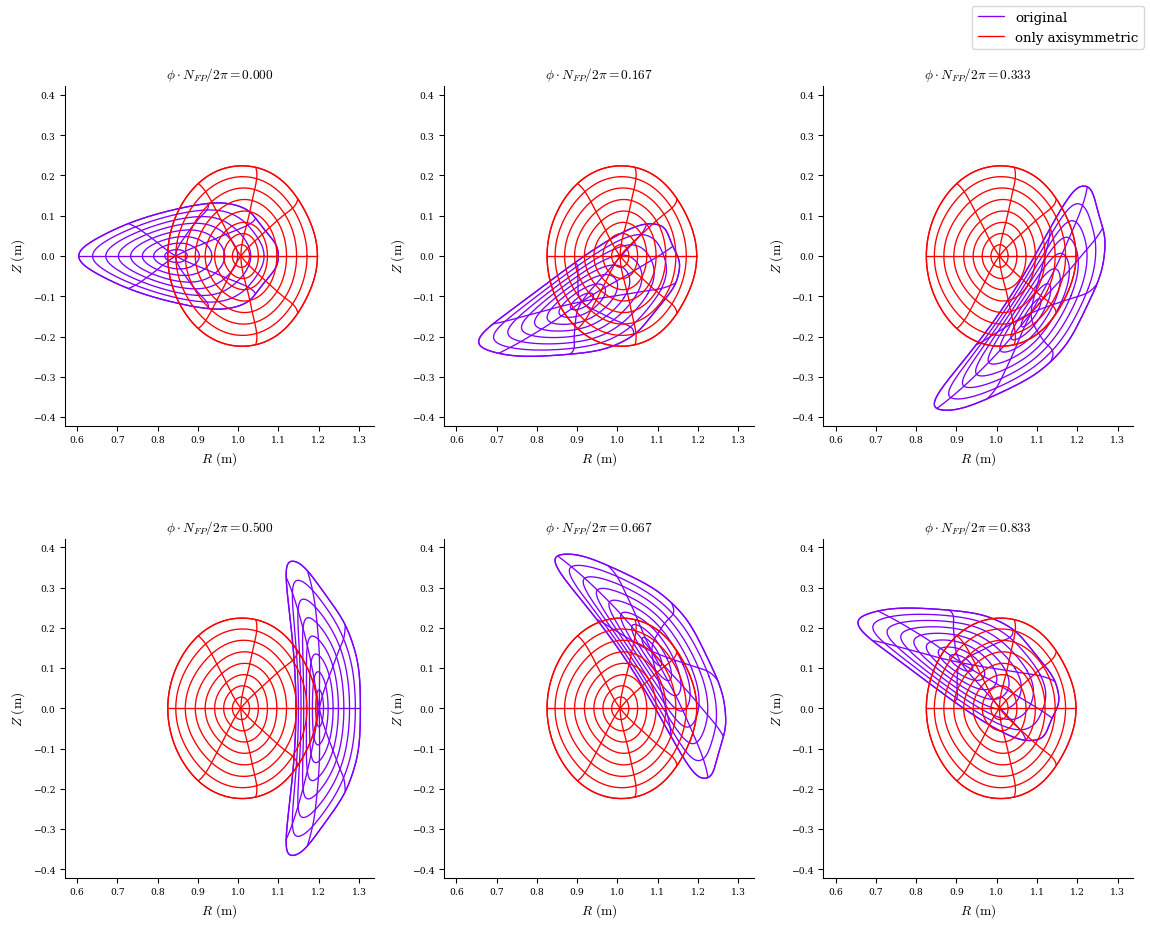

In [14]:
plot_comparison(eqs=[eq0, eq_poincare], labels=["original", "only axisymmetric"]);

Building objective: force


Precomputing transforms
Timer: Precomputing transforms = 107 ms
Timer: Objective build = 124 ms
Building objective: fix mode R
Building objective: fix mode Z
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: axis R self consistency
Building objective: axis Z self consistency
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: lambda gauge
Timer: Objective build = 350 ms
Timer: LinearConstraintProjection build = 5.31 sec
Number of parameters: 3745
Number of objectives: 11250
Timer: Initializing the optimization = 6.44 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.215e-06                                    1.559e-03   
       1              2          7.595e-08      1.139e-06      5.000e-01      1.949e-04   
       2              3     

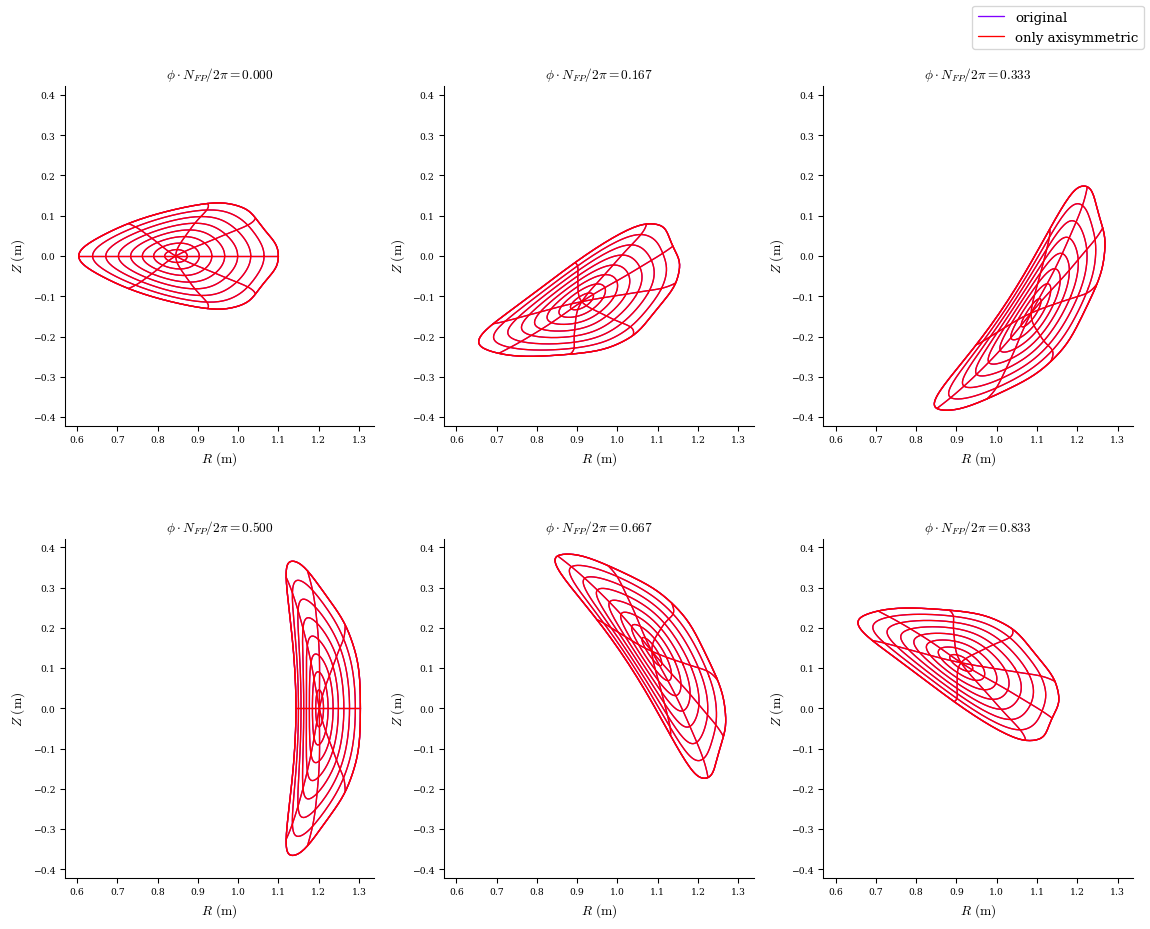

In [15]:
solve_step(eq, maxiter=20, plot=True, ftol=0, gtol=0, xtol=0)